In [7]:
import csv
import numpy
import scipy.stats as st
import json
import requests
from operator import itemgetter
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY = os.getenv("API_KEY")

def csv_to_json():
    response = requests.get(
        f"https://api.freecurrencyapi.com/v1/latest?apikey={API_KEY}&currencies="
    )
    if response.status_code == 200:
        print("Currency conversions API queried successfully. Analyzing data...")
    else:
        print(f"There was an error querying the currency conversions API. Error code: {response.status_code}")
        return
    json_response = response.json()
    print(json_response)
    with open('multi-thread-raw.csv', "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        with open("template.json", "r") as template:
            data = json.load(template)
            i = -1
            for row in csv_reader:
                if line_count > 0:
                    host_found = False
                    node = row[7]
                    price_string = row[4]
                    if price_string == "N/A":
                        price = "N/A"
                        price_num = -1
                    else:
                        price_units = price_string.split(" ")[1]
                        price_num = round(float(price_string.split(" ")[0]), 2)
                        if price_units != "USD":
                            price_num = round(float(price_string.split(" ")[0]) / json_response["data"][price_units], 2)
                        price = f"${price_num}"
                        if price[len(price)-2] == ".":
                            price = f"{price}0"
                    plan = f"{row[0]} {row[1]} {row[2]} {row[3]} ({price})"
                    for host in data["hosts"]:
                        if host["name"] == plan:
                            trial_added = False
                            for trial in host["trials"]:
                                if trial["node"] == node and trial["node"] != "N/A":
                                    trial["samples"] = trial["samples"] + 1
                                    trial["cps"] = (trial["cps"] + float(row[5])) / trial["samples"]
                                    trial_added = True
                                    host_found = True
                            if not trial_added:
                                host["trials"].append({
                                    "cps": float(row[5]),
                                    "node": row[7],
                                    "samples": 1
                                })
                                host_found = True
                    if not host_found:
                        data["hosts"].append({
                            "name": plan,
                            "price": price_num,
                            "trials": [
                                {
                                    "cps": float(row[5]),
                                    "node": row[7],
                                    "samples": 1
                                }
                            ]
                        })
                        i += 1
                    with open('multi-thread.json', 'w') as file:
                        data['hosts'].sort(key=itemgetter('price'), reverse=True)
                        file.write(json.dumps(data, indent=2))
                    file.close()
                line_count += 1
    with open('single-thread-raw.csv', "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 0
        with open("template.json", "r") as template:
            data = json.load(template)
            i = -1
            for row in csv_reader:
                if line_count > 0:
                    host_found = False
                    node = row[7]
                    price_string = row[4]
                    if price_string == "N/A":
                        price = "N/A"
                        price_num = -1
                    else:
                        price_units = price_string.split(" ")[1]
                        price_num = round(float(price_string.split(" ")[0]), 2)
                        if price_units != "USD":
                            price_num = round(float(price_string.split(" ")[0]) / json_response["data"][price_units], 2)
                        price = f"${price_num}"
                        if price[len(price)-2] == ".":
                            price = f"{price}0"
                    plan = f"{row[0]} {row[1]} {row[2]} {row[3]} ({price})"
                    for host in data["hosts"]:
                        if host["name"] == plan:
                            trial_added = False
                            for trial in host["trials"]:
                                if trial["node"] == node and trial["node"] != "N/A":
                                    trial["samples"] = trial["samples"] + 1
                                    trial["mspt"] = (trial["mspt"] + float(row[5])) / trial["samples"]
                                    trial["tps"] = 1000/trial["mspt"]
                                    trial_added = True
                                    host_found = True
                            if not trial_added:
                                host["trials"].append({
                                    "mspt": float(row[5]),
                                    "tps": 1000/float(row[5]),
                                    "node": node,
                                    "samples": 1
                                })
                                host_found = True
                    if not host_found:
                        data["hosts"].append({
                            "name": plan,
                            "price": price_num,
                            "trials": [
                                {
                                    "mspt": float(row[5]),
                                    "tps": 1000/float(row[5]),
                                    "node": node,
                                    "samples": 1
                                }
                            ]
                        })
                        i += 1
                    with open('single-thread.json', 'w') as file:
                        data['hosts'].sort(key=itemgetter('price'), reverse=True)
                        file.write(json.dumps(data, indent=2))
                    file.close()
                line_count += 1


def json_to_csv():
    with open('multi-thread.json', 'r') as file:
        data = json.load(file)
    file.close()
    with open('multi-thread-temp.csv', 'w', newline="") as file:
        csv_writer = csv.writer(file, delimiter=',')
        csv_writer.writerow(['Plan', 'CPS', 'ME'])
        for host in data["hosts"]:
            cps_list = []
            margin_of_error = 0
            for trial in host["trials"]:
                cps_list.append(float(trial["cps"]))
            if len(cps_list) >= 3:
                interval = st.t.interval(confidence=0.95, df=len(cps_list)-1, loc=numpy.mean(cps_list), scale=st.sem(cps_list))
                margin_of_error = round(numpy.mean(cps_list) - interval[0], 2)
            mean = round(numpy.mean(cps_list), 2)
            plan = host["name"]
            csv_writer.writerow([plan, mean, margin_of_error])
    with open('single-thread.json', 'r') as file:
        data = json.load(file)
    file.close()
    with open('single-thread-temp.csv', 'w', newline="") as file:
        csv_writer = csv.writer(file, delimiter=',')
        csv_writer.writerow(['Plan', 'TPS', 'ME'])
        for host in data["hosts"]:
            tps_list = []
            margin_of_error = 0
            for trial in host["trials"]:
                tps_list.append(float(trial["tps"]))
            if len(tps_list) >= 3:
                interval = st.t.interval(confidence=0.95, df=len(tps_list)-1, loc=numpy.mean(tps_list), scale=st.sem(tps_list))
                margin_of_error = round(numpy.mean(tps_list) - interval[0], 2)
            mean = round(numpy.mean(tps_list), 2)
            plan = host["name"]
            csv_writer.writerow([plan, mean, margin_of_error])


def standardize():
    print("Data successfully analyzed. Standardizing data...")
    with open('multi-thread-temp.csv', 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        for row in csv_reader:
            if row[0] == "GLOBAL Baseline G4400 4GB (N/A)":
                st_value = 100/float(row[1])
        i = 0
        with open('multi-thread-temp.csv', 'r') as file:
            csv_reader = csv.reader(file, delimiter=',')
            with open('multi-thread-results.csv', 'w', newline='') as file:
                csv_writer = csv.writer(file, delimiter=',')
                for row in csv_reader:
                    if i == 0:
                        csv_writer.writerow(['Plan', 'Score', 'ME'])
                    if i > 0:
                        plan = row[0]
                        st_score = round(float(row[1])*st_value)
                        st_me = round(float(row[2])*st_value,2)
                        csv_writer.writerow([plan, st_score, st_me])
                    i += 1
    with open('single-thread-temp.csv', 'r') as file:
        csv_reader = csv.reader(file, delimiter=',')
        for row in csv_reader:
            if row[0] == "GLOBAL Baseline G4400 4GB (N/A)":
                st_value = 100/float(row[1])
        i = 0
        with open('single-thread-temp.csv', 'r') as file:
            csv_reader = csv.reader(file, delimiter=',')
            with open('single-thread-results.csv', 'w', newline='') as file:
                csv_writer = csv.writer(file, delimiter=',')
                for row in csv_reader:
                    if i == 0:
                        csv_writer.writerow(['Plan', 'Score', 'ME'])
                    if i > 0:
                        plan = row[0]
                        st_score = round(float(row[1])*st_value)
                        st_me = round(float(row[2])*st_value, 2)
                        csv_writer.writerow([plan, st_score, st_me])
                    i += 1
    print("Data successfully standardized. Please view the results in single-thread-results.csv and multi-thread-results.csv")


csv_to_json()
json_to_csv()
standardize()


Currency conversions API queried successfully. Analyzing data...
{'data': {'AUD': 1.5025602248, 'BGN': 1.7788301945, 'BRL': 4.8729106577, 'CAD': 1.3567901771, 'CHF': 0.8772201, 'CNY': 7.1319408507, 'CZK': 22.0073826554, 'DKK': 6.7733911544, 'EUR': 0.9088801289, 'GBP': 0.7867801089, 'HKD': 7.7937908281, 'HRK': 7.0420807393, 'HUF': 342.4993252571, 'IDR': 15385.247146857, 'ILS': 3.6903104448, 'INR': 83.2110045262, 'ISK': 136.9879318032, 'JPY': 147.0633798163, 'KRW': 1285.1671603699, 'MXN': 17.12575234, 'MYR': 4.6667806656, 'NOK': 10.6048713497, 'NZD': 1.6272903236, 'PHP': 55.3640859957, 'PLN': 3.921680744, 'RON': 4.5172205824, 'RUB': 88.7758725333, 'SEK': 10.3083419982, 'SGD': 1.3302702656, 'THB': 34.6735345087, 'TRY': 28.8985135825, 'USD': 1, 'ZAR': 18.5749934749}}
Data successfully analyzed. Standardizing data...
Data successfully standardized. Please view the results in single-thread-results.csv and multi-thread-results.csv


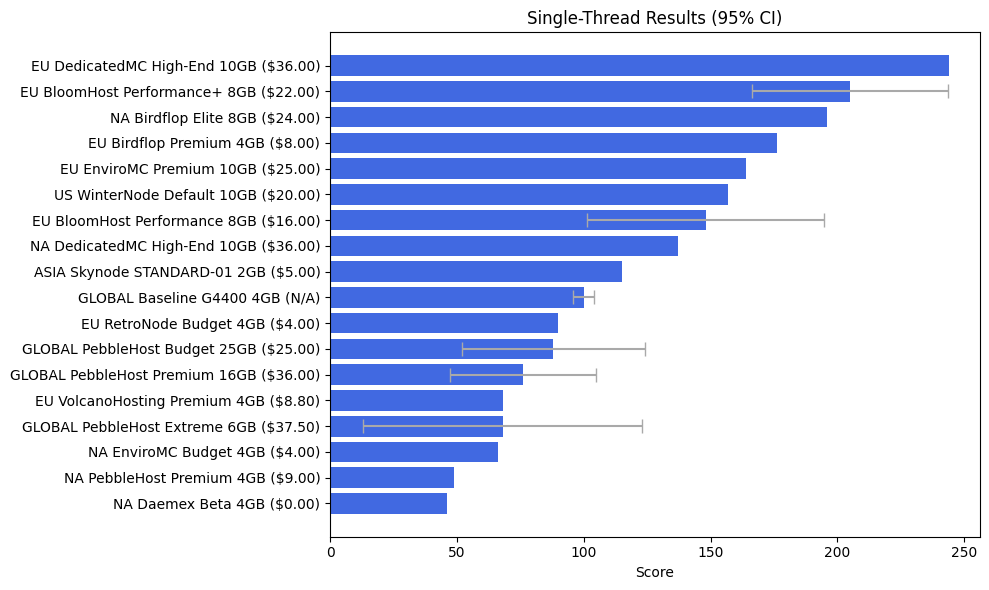

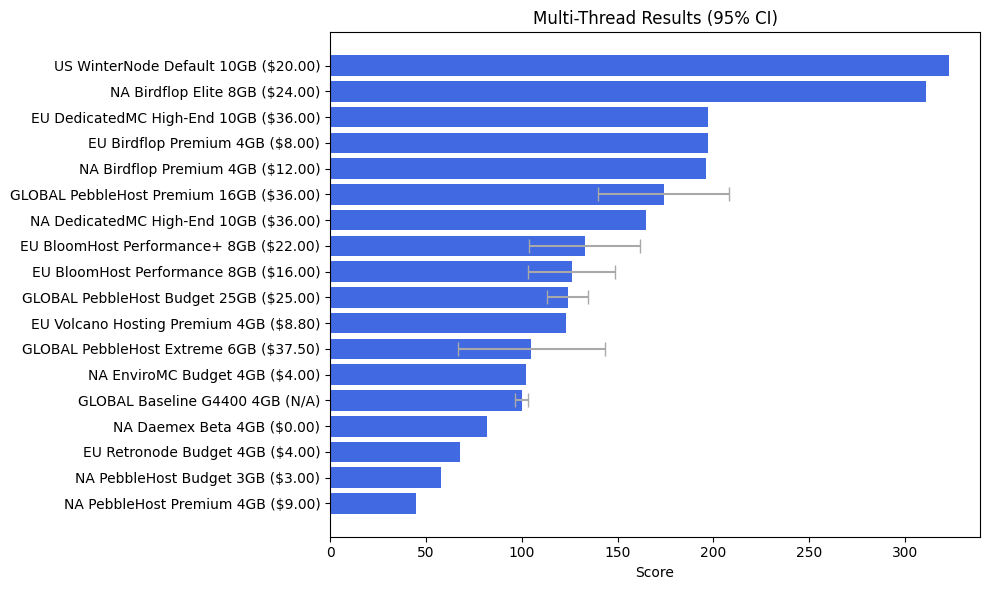

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_horizontal_bar_data(df, title):
    """
    Plots a horizontal bar graph with error bars representing the 95% CI.

    Args:
    df (DataFrame): The dataframe containing the data to be plotted.
    title (str): The title of the plot.
    """
    # Sort by Score for better visualization
    df_sorted = df.sort_values(by='Score')
    # df_sorted = df
    
    # Determine which error bars to show (non-zero ME values)
    error = df_sorted['ME'].apply(lambda x: x if x > 0 else None)


    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(df_sorted['Plan'], df_sorted['Score'], xerr=error, color='royalblue', ecolor='darkgray', capsize=5)
    plt.xlabel('Score')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def run_graph_analysis():
    # Load the CSV files
    single_thread_data = pd.read_csv('single-thread-results.csv')
    multi_thread_data = pd.read_csv('multi-thread-results.csv')

    # Plot for single-thread data with horizontal bars
    plot_horizontal_bar_data(single_thread_data, 'Single-Thread Results (95% CI)')

    # Plot for multi-thread data with horizontal bars
    plot_horizontal_bar_data(multi_thread_data, 'Multi-Thread Results (95% CI)')
    
run_graph_analysis()